# Introduction

according to Youtube, the criteria for 'trending video' is 
1) View count
2) Rate of increase in views (i.e., “momentum” or “temperature”)
3) Sources that generate views, including external sources outside of YouTube
4) Video upload date

with the data that we have, we can figure out what factors might influence 1) View count

I divided this analysis into 4 different steps ;

#### Subtopic 1: The Impact of Category and Channel on Views
In this subtopic, the analysis focused on understanding how category and channel influence view counts. By calculating the average views, likes, dislikes, and comment counts across different categories, it was found that certain genres, like Comedy, tend to attract higher views. This indicates that specific content types or genres can play a significant role in boosting viewership.
#### Subtopic 2: The Effect of Title Length, Description Length, and Tag Count
This section explored how title length, description length, and tag count impact view counts. Through simple and multiple regression analysis, it was observed that description length and tag count have a slight positive effect on views, while title length has almost no impact. However, the overall explanatory power of these variables was limited, suggesting that these elements alone are insufficient to explain variations in view counts.
#### Subtopic 3: Time Until a Video Becomes Trending
Here, the analysis examined the relationship between the time it takes for a video to trend and its view count. A weak positive correlation was identified, indicating that videos that trend quickly tend to have higher views. However, this relationship is not strong, suggesting that factors beyond trending speed are more influential in driving viewership.
#### Subtopic 4: Correlation Analysis of Variables
The final subtopic involved conducting an overall correlation analysis to identify which variables are most strongly associated with view counts. Likes, dislikes, and comment count showed relatively strong correlations with views, particularly likes and dislikes, which emerged as major influencing factors. In contrast, variables like tag_count, title_length, and description_length exhibited low correlations with views, indicating that they have a minimal effect on viewership.

In [3]:
import pandas as pd 

In [4]:
with open("/Users/jeonjj/Document/UIUC/archive/KRvideos.csv", "rt", encoding="utf8",errors='ignore') as f:
    youtube_kr = pd.read_csv(f)

### because Jupyter notebook cannot correctly read Korean character, I used 'with' phrase and more modifications
### if you guys working on english-only files, then you can just use "pd.read_csv()"
### OTHERWISE, just ask CHAT GPT if some other problems happens

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS 

In [6]:
youtube_kr['publish_time']

0        2017-11-13T07:07:36.000Z
1        2017-11-13T10:59:16.000Z
2        2017-11-11T07:16:08.000Z
3        2017-11-12T11:19:52.000Z
4        2017-11-13T11:08:59.000Z
                   ...           
34562    2018-06-10T23:00:01.000Z
34563    2018-06-12T07:00:06.000Z
34564    2018-06-12T13:17:29.000Z
34565    2018-06-11T11:57:20.000Z
34566    2018-06-10T20:00:01.000Z
Name: publish_time, Length: 34567, dtype: object

# 0. Preprocessing

In [7]:
youtube_kr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34567 entries, 0 to 34566
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                34567 non-null  object
 1   trending_date           34567 non-null  object
 2   title                   34567 non-null  object
 3   channel_title           34567 non-null  object
 4   category_id             34567 non-null  int64 
 5   publish_time            34567 non-null  object
 6   tags                    34567 non-null  object
 7   views                   34567 non-null  int64 
 8   likes                   34567 non-null  int64 
 9   dislikes                34567 non-null  int64 
 10  comment_count           34567 non-null  int64 
 11  thumbnail_link          34567 non-null  object
 12  comments_disabled       34567 non-null  bool  
 13  ratings_disabled        34567 non-null  bool  
 14  video_error_or_removed  34567 non-null  bool  
 15  de

#### 34,567 data, and there are N/A in description

## 0.1 select columns that we want to see

In [8]:
df = youtube_kr[:]


# delete columns that we don't use for this analysis
for col in ["thumbnail_link", "comments_disabled", "ratings_disabled", "video_error_or_removed"]:
    del df[col] 

## 0.2 check whether 'video_id' can be a index (primary key)

In [9]:
df["video_id"].duplicated().value_counts()

video_id
True     18691
False    15876
Name: count, dtype: int64

#### If a video became a trending video on multiple dates, data was recorded for each date. For this analysis, we will only use data from the first time a video became trending during the specified period. Remove duplicate video_ids

In [10]:
df = df.drop_duplicates(["video_id"])[:]

df["video_id"].duplicated().value_counts()

video_id
False    15876
Name: count, dtype: int64

## 0.3 using 'category_id' and JSON file, create 'category' column

In [11]:
import json  

id_to_category = {}

with open("/Users/jeonjj/Document/UIUC/archive/KR_category_id.json","r") as f:
    id_data = json.load(f)
    for category in id_data["items"]:
        id_to_category[category["id"]] = category["snippet"]["title"]

# id_to_category

df["category_id"] = df["category_id"].astype(str)
df.insert(4, "category", df["category_id"].map(id_to_category))

In [12]:
df.isnull().sum()

video_id            0
trending_date       0
title               0
channel_title       0
category          119
category_id         0
publish_time        0
tags                0
views               0
likes               0
dislikes            0
comment_count       0
description      1602
dtype: int64

#### There are N/A values in category columns

In [13]:
# to figure out at where in JSON N/A values are

df["category_id"].loc[df["category"].isnull() == True].value_counts()

category_id
29    119
Name: count, dtype: int64

#### Result above means category_id 29 has no category value
#### if you search on Youtube manually, you can find it was about Nonprofits&Activism

In [14]:
# fill missing value with 'nonprofits & activism'

df.loc[df["category"].isnull(), "category"] = "Nonprofits & Activism"


## 0.4 Transform trending_date & publish_time data to datetime

In [15]:
youtube_kr["trending_date"] = pd.to_datetime(youtube_kr["trending_date"], format = "%y.%d.%m")

df["trending_date"] = pd.to_datetime(df["trending_date"], format = "%y.%d.%m")

df["publish_time"] = pd.to_datetime(df["publish_time"])
df["publish_time"] = df["publish_time"].apply(lambda x : x.date())
df["publish_time"] = pd.to_datetime(df["publish_time"])

## 0.5 making 'tag_count' column

In [16]:
df["tag_count"] = df["tags"].apply(lambda x : len(x.split("|")) if x != "[none]" else 0)

## 0.6 Ratio (likes/views, dislikes/views, comment_count/views, dislikes/likes)

In [17]:
df["likes/views"] = df["likes"] / df["views"]
df["dislikes/views"] = df["dislikes"] / df["views"]
df["comment_count/views"] = df["comment_count"] / df["views"]
df["dislikes/likes"] = df["dislikes"] / df["likes"]


df.loc[df["dislikes/likes"] == np.inf, "dislikes/likes"] = 0
df.loc[df["dislikes/likes"].isnull(), "dislikes/likes"] = 0


## 0.7 making 'title_length' column using the title

In [18]:
df["title_length"] = df["title"].apply(lambda x : len(str(x)) if pd.isnull(x) == False  else 0 )

## 0.8 making 'description_length' column

In [19]:
df["description_length"] = df["description"].apply(lambda x : len(str(x)) if pd.isnull(x) == False  else 0 )

## 0.9 treTime-pubTime : it represents the time elapsed from the video’s publication to when it became a trending video. 

In [20]:
from datetime import timedelta


df["treTime-pubTime"] = df["trending_date"] - df["publish_time"] + timedelta(days = 1)

## 0.10 Manage outlier in views column

<Axes: ylabel='views'>

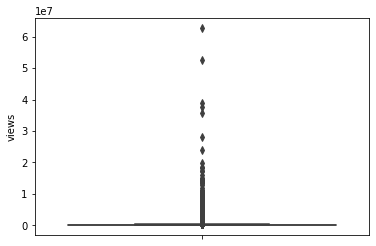

In [21]:
sns.boxplot(y=df["views"])


### I can say that there are outlier 
### the reason why boxplot doesn't have 'box' is because of the outlier

In [22]:
# To delete the outllier, we just see the data between Q1-1.5*IQR ~ Q3+1.5*IQR

Q1 = df['views'].quantile(0.25)
Q3 = df['views'].quantile(0.75)
IQR = Q3 - Q1


df = df[(df['views'] >= Q1 - 1.5 * IQR) & (df['views'] <= Q3 + 1.5 * IQR)]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='views', ylabel='Count'>

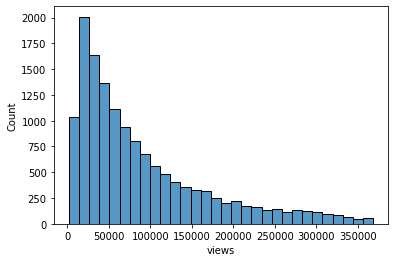

In [23]:
sns.histplot(df['views'], bins=30)


In [23]:
df.to_csv("/Users/jeonjj/Desktop/youtube_kr.csv")

# 1. Analysis of Popularity Factors by Category and Channel

### 1.1 identifying averages of views, likes, dislikes, comment_count based on the category and channel

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# calculate averages of views, likes, dislikes, comment_count

category_stats = df.groupby('category').agg({
    'views': 'mean',
    'likes': 'mean',
    'dislikes': 'mean',
    'comment_count': 'mean'
}).reset_index()


# Identify Top Categories by Sorting in Descending Order of Average View Count
category_stats = category_stats.sort_values(by='views', ascending=False)
print(category_stats.head())


            category          views        likes   dislikes  comment_count
1             Comedy  149977.714080  2826.359195  84.619253     968.472701
14            Sports  123585.458861   687.262658  42.601266     273.905063
16   Travel & Events  114205.270270   966.621622  54.135135     327.972973
11    Pets & Animals  112859.316327  3426.319728  35.595238     618.149660
4   Film & Animation  107566.575325  1285.010390  48.774026     437.958442


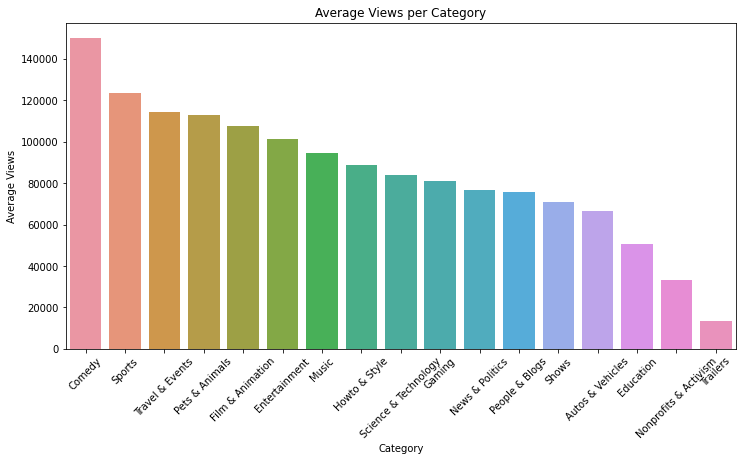

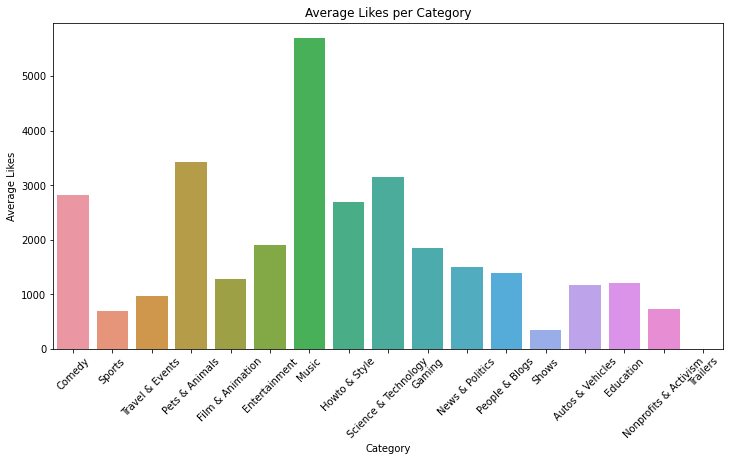

In [25]:
# Visualize Category-wise Differences in View Count and Like Count Using a Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(data=category_stats, x='category', y='views')
plt.xticks(rotation=45)
plt.title('Average Views per Category')
plt.ylabel('Average Views')
plt.xlabel('Category')
plt.show()

# Visualization of Like Counts
plt.figure(figsize=(12, 6))
sns.barplot(data=category_stats, x='category', y='likes')
plt.xticks(rotation=45)
plt.title('Average Likes per Category')
plt.ylabel('Average Likes')
plt.xlabel('Category')
plt.show()


### 1.2 See those differences are statistically significant by doing ANOVA 

In [26]:
from scipy.stats import f_oneway

# Group View Count Data by Category to Create a List for ANOVA
category_views = [df[df['category'] == category]['views'].values for category in df['category'].unique()]

# ANOVA
anova_result = f_oneway(*category_views)
print("ANOVA result:", anova_result)


ANOVA result: F_onewayResult(statistic=61.34596353508163, pvalue=7.32886847743645e-192)


#### because p-value is way below 0.05, we can say that the difference is significant

### 1.3 Because the difference is statistically significant, we need to figure out which category is more contribute to the outcome by using "Tukey's HSD test"

In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey's HSD test
tukey_result = pairwise_tukeyhsd(df['views'], df['category'])
print(tukey_result)


                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
        group1                group2          meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------------------------------------
     Autos & Vehicles                Comedy   83185.1985    0.0   48264.4665 118105.9304   True
     Autos & Vehicles             Education  -16133.3004 0.9896  -54044.6879  21778.0871  False
     Autos & Vehicles         Entertainment   34503.3659 0.0385     779.8558  68226.8759   True
     Autos & Vehicles      Film & Animation   40774.0597 0.0058    5994.9208  75553.1986   True
     Autos & Vehicles                Gaming   14253.8158 0.9943  -21187.5448  49695.1764  False
     Autos & Vehicles         Howto & Style   21859.7012 0.8506  -15995.5334  59714.9358  False
     Autos & Vehicles                 Music   27593.5067 0.3557   -7759.8988  62946.9123  False
     Autos & Vehicles       News & Polit

## Conclusion for #1

In this study, we analyzed view count differences across categories of popular YouTube videos to investigate which categories have the most substantial impact on driving high view counts. The results from the ANOVA analysis revealed that the differences in view counts across categories are statistically significant, indicating that certain types of content are more likely to attract higher view counts compared to others.

Additionally, a Tukey HSD post-hoc test was conducted to examine specific category pairs with significant differences in view counts. The analysis showed that the Comedy category had the highest average view count and exhibited statistically significant differences from various other categories. This finding suggests a strong preference among YouTube users for Comedy content, highlighting that Comedy videos have a greater influence in generating higher view counts compared to other content types.

Thus, prioritizing the Comedy category could be an effective strategy for maximizing view counts on YouTube. Furthermore, categories such as Sports and Travel & Events also recorded high average view counts, indicating that content within these categories has a relatively high potential for attracting views in addition to Comedy.

Additional Insights and Strategy Recommendations

Enhancing Comedy Content: Given Comedy’s positive impact on view counts, creating content that emphasizes humor and entertainment elements may be advantageous for increasing audience engagement.
Combining Categories for Greater Appeal: By blending Comedy elements with top-performing categories like Sports or Travel & Events, creators may be able to generate even greater viewership. For example, content that combines comedy with sports themes could resonate strongly with viewers.
Conclusion This analysis confirms that the Comedy category has the most significant influence on YouTube view counts, suggesting that Comedy content enjoys greater popularity relative to other categories. These findings provide practical strategic direction for YouTube content planners aiming to maximize view counts, underscoring the importance of considering the Comedy category when designing content strategies.

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14172 entries, 0 to 34561
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   video_id             14172 non-null  object         
 1   trending_date        14172 non-null  datetime64[ns] 
 2   title                14172 non-null  object         
 3   channel_title        14172 non-null  object         
 4   category             14172 non-null  object         
 5   category_id          14172 non-null  object         
 6   publish_time         14172 non-null  datetime64[ns] 
 7   tags                 14172 non-null  object         
 8   views                14172 non-null  int64          
 9   likes                14172 non-null  int64          
 10  dislikes             14172 non-null  int64          
 11  comment_count        14172 non-null  int64          
 12  description          12645 non-null  object         
 13  tag_count            

# 2. The effect of other variables ('views', 'title_length', 'description_length', 'tag_count')

### 2.1 Firstly, we need to see the basic relation between those variables using basic correlation

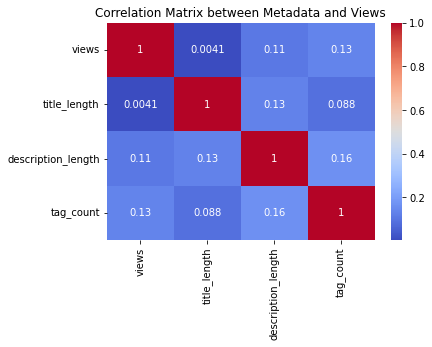

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# select columns that we need
correlation_data = df[['views', 'title_length', 'description_length', 'tag_count']]

# calucate correlation and visualize
correlation_matrix = correlation_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix between Metadata and Views")
plt.show()


### 2.2 For more detailed analysis, I did simple linear regression

In [29]:
# simple Linear Regression

import statsmodels.api as sm


def simple_regression(x_var):
    X = df[[x_var]]
    X = sm.add_constant(X)  
    y = df['views']
    model = sm.OLS(y, X).fit()  
    print(f"the result of regression ({x_var}and views):\n", model.summary())

# regressions analysis for each of the title_length, description_length, tag_count 
simple_regression('title_length')
simple_regression('description_length')
simple_regression('tag_count')


the result of regression (title_lengthand views):
                             OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2399
Date:                Sat, 07 Dec 2024   Prob (F-statistic):              0.624
Time:                        16:26:40   Log-Likelihood:            -1.8009e+05
No. Observations:               14172   AIC:                         3.602e+05
Df Residuals:                   14170   BIC:                         3.602e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

#### result for simple linear regression

Views and Title Length
R-squared: 0.000 (almost no correlation)
Coefficient: 17.28 (not statistically significant, p-value = 0.624)
Summary: title_length does not have a significant impact on views.
Views and Description Length
R-squared: 0.011 (very weak positive correlation)
Coefficient: 20.46 (statistically significant, p-value < 0.001)
Summary: Although description_length shows a slight positive trend with views, the effect is minimal.
Views and Tag Count
R-squared: 0.018 (weak positive correlation)
Coefficient: 541.80 (statistically significant, p-value < 0.001)
Summary: tag_count tends to increase with views, and among the three variables, it has the largest influence on views, though the impact remains modest.
Overall Summary: None of the three variables strongly impacts views, as the R-squared values are low, indicating that the simple regression models have very limited explanatory power. While description_length and tag_count are statistically significant, their actual influence on views is weak.

### 2.3 To include more complex relationship, also did multiple regression analysis

In [30]:
# making title_length, description_length, tag_count as predictors
X = df[['title_length', 'description_length', 'tag_count']]
X = sm.add_constant(X)  # add intercept
y = df['views']

multiple_regression_model = sm.OLS(y, X).fit()
print("result of multiple regression :\n", multiple_regression_model.summary())


result of multiple regression :
                             OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     122.8
Date:                Sat, 07 Dec 2024   Prob (F-statistic):           1.57e-78
Time:                        16:26:44   Log-Likelihood:            -1.7990e+05
No. Observations:               14172   AIC:                         3.598e+05
Df Residuals:                   14168   BIC:                         3.598e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
con

#### result for multiple linear regression

In the correlation matrix of the correlation analysis, title_length, description_length, and tag_count all show a positive correlation with views, though the correlation coefficients are relatively low. The highest correlation coefficient is between tag_count and views, at 0.13, which indicates a weak positive correlation. This suggests that these metadata variables have only a minor impact on view counts.

Simple Linear Regression Analysis:

title_length and views: The R-squared value is 0.000, indicating that title_length has almost no effect on view counts. Additionally, the p-value is 0.624, which is not significant, suggesting that title_length does not contribute to predicting view counts.
description_length and views: The R-squared value is 0.011, suggesting that description_length has a minor impact on view counts. Since the p-value is significantly low (p < 0.05), we can conclude that the effect of description_length on view counts is statistically significant.
tag_count and views: The R-squared value is 0.018, meaning that tag_count has a slightly stronger effect on view counts. The p-value is also significantly low (p < 0.05), indicating that tag_count has a statistically significant effect on view counts.
Multiple Regression Analysis:

Overall model explanation (R-squared): The R-squared value of the multiple regression model is 0.025, which indicates that these three variables collectively explain approximately 2.5% of the variance in view counts. This low explanatory power suggests that metadata has limited impact on view counts.
Significance of each variable:
title_length: With a p-value of 0.03, it shows a weak level of significance and has a negative coefficient value of -76.2622, suggesting that as the title length increases, views may slightly decrease.
description_length: With a p-value of 0.000, it has a statistically significant effect on views, with a positive coefficient of 17.0793, indicating that longer descriptions tend to increase view counts.
tag_count: With a p-value of 0.000, it also shows a significant effect on views, with a positive coefficient of 489.6197, suggesting that a higher number of tags is associated with increased view counts.
Final Interpretation: Both description_length and tag_count have significant positive effects on view counts, meaning that videos with longer descriptions and more tags are likely to receive higher view counts. However, title_length has a minimal effect on views, and in the multiple regression analysis, it even shows a slight negative impact, implying that excessively long titles may not be beneficial. The low R-squared value indicates that metadata variables alone cannot sufficiently predict view counts, suggesting that other factors (such as content topic, watch time, etc.) may also need to be considered.

Based on these findings, focusing on creating rich descriptions and using a sufficient number of tags may help increase view counts. Additionally, optimizing title length rather than extending it excessively could improve the approach.

In [33]:
df.to_csv("/Users/jeonjj/Desktop/youtubeKR.csv")

,video_id,trending_date,title,channel_title,category,category_id,publish_time,tags,views,likes,...,tag_count,likes/views,dislikes/views,comment_count/views,dislikes/likes,title_length,description_length,treTime-pubTime,days_to_trend,trend_speed_group


# 3. Time until a video becomes trending content

  trend_speed_group         views
0      Within 1 day           NaN
1          1-3 days  90867.143581
2          3-7 days  88458.975514
3    7 days or more  53380.917197
Correlation between trending speed and view count:
                days_to_trend     views
days_to_trend       1.000000 -0.015357
views              -0.015357  1.000000


/var/folders/c7/3twkz4l56717vzlzq7l2yhzh0000gn/T/ipykernel_73098/3681948308.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_views = df.groupby('trend_speed_group')['views'].mean().reset_index()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


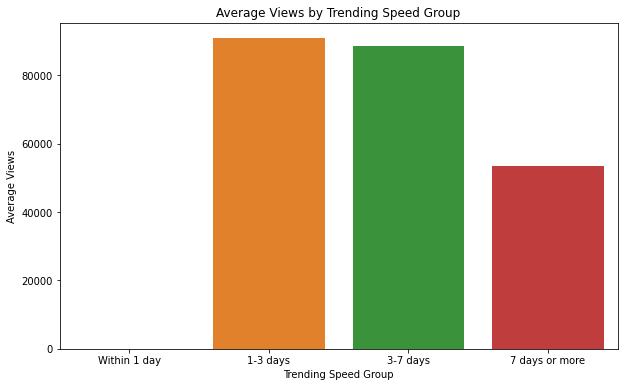

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert `treTime-pubTime` to days and add a new column
df['days_to_trend'] = df['treTime-pubTime'].dt.days

# 2. Group by `days_to_trend` to calculate average views within specific time intervals
# Example: within 1 day, 1-3 days, 3-7 days, 7 days and beyond
bins = [0, 1, 3, 7, df['days_to_trend'].max()]  # Define time intervals
labels = ['Within 1 day', '1-3 days', '3-7 days', '7 days or more']  # Labels for each interval
df['trend_speed_group'] = pd.cut(df['days_to_trend'], bins=bins, labels=labels, right=False)

# Calculate the average views for each group
grouped_views = df.groupby('trend_speed_group')['views'].mean().reset_index()
print(grouped_views)

# 3. Correlation analysis
correlation = df[['days_to_trend', 'views']].corr()
print("Correlation between trending speed and view count:\n", correlation)

# 4. Visualization: Visualize average views for each trend speed group
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_views, x='trend_speed_group', y='views')
plt.title("Average Views by Trending Speed Group")
plt.xlabel("Trending Speed Group")
plt.ylabel("Average Views")
plt.show()


### result for #3


#### description
* Average Views by Group Analysis: The average view count is highest in the 1-3 day group, with approximately 90,867 views, followed by the 3-7 day group (88,458 views), and then the 7 days or more group (53,380 views). The "Within 1 day" group has a value of NaN, indicating that there is no data for videos that trended within 1 day, suggesting that no videos in the dataset reached trending status within a day.

* Correlation Between Trending Speed and View Count: The correlation coefficient between days_to_trend and views is -0.015357, showing a very weak negative correlation. This suggests that the shorter the time to trend, the slightly higher the view count tends to be, although the impact is minimal.

#### Interpretation
1) Relationship Between Trending Speed and View Count: Videos that trend within 1-3 days or 3-7 days tend to achieve relatively higher average view counts, whereas those taking 7 days or more to trend have lower view counts. This implies that faster trending may be associated with higher view counts, although, as indicated by the low correlation coefficient, this effect is quite limited.

2) Strengthening Initial Promotion Strategy: Given that a faster trending speed could potentially have a positive effect on view counts, strengthening the initial promotion strategy may be beneficial. In particular, implementing strategies that encourage initial engagement and reaction within 1-3 days after posting could help increase view counts.

#### Conclusion
This analysis helps clarify the relationship between trending speed and view count, suggesting that reaching trending status quickly may be advantageous for maximizing views. However, given the low correlation coefficient, other factors beyond trending speed likely play a significant role in driving view counts. Further analysis, such as multiple regression analysis, could examine the combined effects of other factors (like category, like-to-view ratio, etc.) along with trending speed on view counts.








In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14172 entries, 0 to 34561
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   video_id             14172 non-null  object         
 1   trending_date        14172 non-null  datetime64[ns] 
 2   title                14172 non-null  object         
 3   channel_title        14172 non-null  object         
 4   category             14172 non-null  object         
 5   category_id          14172 non-null  object         
 6   publish_time         14172 non-null  datetime64[ns] 
 7   tags                 14172 non-null  object         
 8   views                14172 non-null  int64          
 9   likes                14172 non-null  int64          
 10  dislikes             14172 non-null  int64          
 11  comment_count        14172 non-null  int64          
 12  description          12645 non-null  object         
 13  tag_count            

# 4. Overall Analysis : Put all the values together

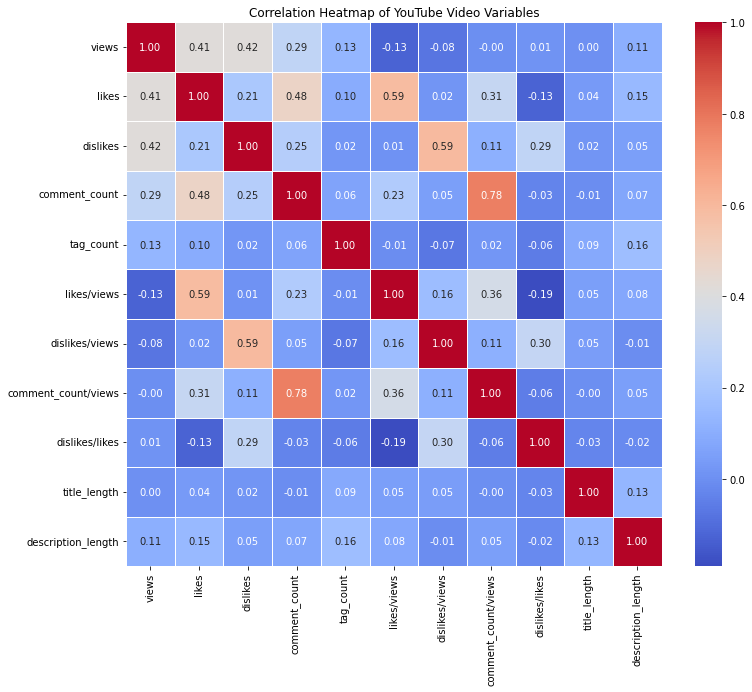

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


df_new = df[['views', 'likes', 'dislikes', 'comment_count', 'tag_count','likes/views','dislikes/views',
            'comment_count/views', 'dislikes/likes', 'title_length', 'description_length']]

# calculate correlation
correlation_matrix = df_new.corr(method="pearson")

# create heatmap
plt.figure(figsize=(12, 10))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of YouTube Video Variables")
plt.show()


### description

Average Views by Group Analysis: The average view count is highest in the 1-3 day group, with approximately 90,867 views, followed by the 3-7 day group (88,458 views), and then the 7 days or more group (53,380 views). The "Within 1 day" group has a value of NaN, indicating that there is no data for videos that trended within 1 day, suggesting that no videos in the dataset reached trending status within a day.

Correlation Between Trending Speed and View Count: The correlation coefficient between days_to_trend and views is -0.015357, showing a very weak negative correlation. This suggests that the shorter the time to trend, the slightly higher the view count tends to be, although the impact is minimal.

Interpretation

Relationship Between Trending Speed and View Count: Videos that trend within 1-3 days or 3-7 days tend to achieve relatively higher average view counts, whereas those taking 7 days or more to trend have lower view counts. This implies that faster trending may be associated with higher view counts, although, as indicated by the low correlation coefficient, this effect is quite limited.
Strengthening Initial Promotion Strategy: Given that a faster trending speed could potentially have a positive effect on view counts, strengthening the initial promotion strategy may be beneficial. In particular, implementing strategies that encourage initial engagement and reaction within 1-3 days after posting could help increase view counts.
Conclusion

This analysis helps clarify the relationship between trending speed and view count, suggesting that reaching trending status quickly may be advantageous for maximizing views. However, given the low correlation coefficient, other factors beyond trending speed likely play a significant role in driving view counts. Further analysis, such as multiple regression analysis, could examine the combined effects of other factors (like category, like-to-view ratio, etc.) along with trending speed on view counts.








# 5. Conclusion Until Now

### 1. Views as the Primary Focus
When views are set as the primary objective, the analysis reveals that the most influential factors for increasing view counts are:

* User Engagement Metrics: Likes, dislikes, and comment count show the strongest correlations with view counts. Videos with more likes and comments tend to have higher views, suggesting that engagement metrics directly influence viewership.

* Category: Certain categories, such as Comedy, have a notable impact on views. This indicates that some genres are inherently more likely to attract viewership due to their popularity or the entertainment value they provide.

* Trending Speed: There is a weak positive correlation between how quickly a video trends and its view count, suggesting that while trending speed can contribute to views, it is not the primary driver.
On the other hand, variables like title length, description length, and tag count have a relatively low influence on views, meaning that simply increasing or modifying these elements is unlikely to significantly boost viewership.


### 2. Factors Influencing the Key Drivers of Views
Since the key drivers of views are user engagement metrics (likes, dislikes, and comment count), it’s essential to identify what influences these specific metrics:

* Likes: To increase likes, the following factors may be influential:
* Category: Some categories inherently draw more positive reactions; for example, entertainment and informative content often receive more likes.
* Tag Count: Videos with a higher tag count may be more discoverable, leading to a broader audience and potentially more likes.
* Title and Description: Compelling titles and clear descriptions can attract attention and motivate viewers to like the content.
* Dislikes: Dislikes are often influenced by:
* View Count: As videos gain more views, they also tend to accumulate more dislikes, possibly due to reaching a diverse audience with varied opinions.
* Category and Video Length: Controversial or sensitive topics may draw more dislikes, and longer videos may lose viewer interest, leading to increased dislikes.
* Comment Count: To encourage more comments, the following aspects are effective:
* Category: Certain topics naturally invite discussion, especially those that provoke thought or emotion.
* Video Content: Videos that ask questions or encourage feedback typically have a higher comment count as viewers are prompted to engage.
* Trending Speed: Videos that trend quickly often have high comment engagement due to the immediate attention they receive.

### 3. Comprehensive Strategy for Managing Key Engagement Metrics
To effectively manage and boost view counts, it’s crucial to focus on the underlying engagement metrics (likes, dislikes, and comments) and the factors that drive them:

1) Content Strategy: Prioritize categories that resonate with audiences, such as entertainment or educational content, to naturally increase engagement. Using popular tags can also help reach a wider audience.
Encouraging Positive Engagement: Using titles and descriptions that draw attention, adding calls to action, and creating content that invites responses can significantly improve likes and comments.

2) Monitoring Dislikes: Understanding and analyzing patterns in dislikes can provide insight into the types of content or formats that may need adjustment to better align with viewer expectations.


#### Summary
In conclusion, focusing on user engagement metrics—particularly likes, dislikes, and comment count—is essential for driving view counts effectively. Building a predictive model that includes these metrics and considers category influence would provide a robust framework for understanding and maximizing viewership. Managing and optimizing the factors influencing engagement will ultimately lead to a stronger impact on views.






